In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from os import listdir
import seaborn as sns
import cv2
import shutil
from glob import glob
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm_notebook as tqdm
import os
#for dirname, _, filenames in os.walk('/kaggle/input/headpose/head_pose_sub_NC150_ses_20190410/'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [2]:
FILEPATH = '/kaggle/input/headpose/head_pose_sub_NC150_ses_20190410/pic/pic/'

## How to lookat the data 

In [3]:
# time and pose 
timepose = pd.read_csv('/kaggle/input/headpose/head_pose_sub_NC150_ses_20190410/head_pose.csv')
pictime = pd.read_csv('/kaggle/input/headpose/head_pose_sub_NC150_ses_20190410/video_frame_times.csv')
pictime.file = pictime.file.apply(lambda x : x.split('/')[-1])
pictime.head()
time2file = {k:v for v,k in pictime.values}
timepose['file'] = timepose.time_sec.apply(lambda x : time2file[x])
timepose.head()  # now we have the auxuality

,rotX,rotY,rotZ,transX,transY,transZ,time_sec,file
0,-0.000160,-0.000249,0.0,-0.003342,0.100802,0.038361,0.0,frame_000211.png
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.3,frame_000250.png
2,-0.000416,0.000000,0.0,-0.003678,0.119079,0.050967,2.6,frame_000289.png
3,-0.000397,0.000250,0.0,0.002390,0.147334,0.028480,3.9,frame_000328.png
4,0.000000,-0.000415,0.0,-0.009098,0.044274,-0.005990,5.2,frame_000367.png


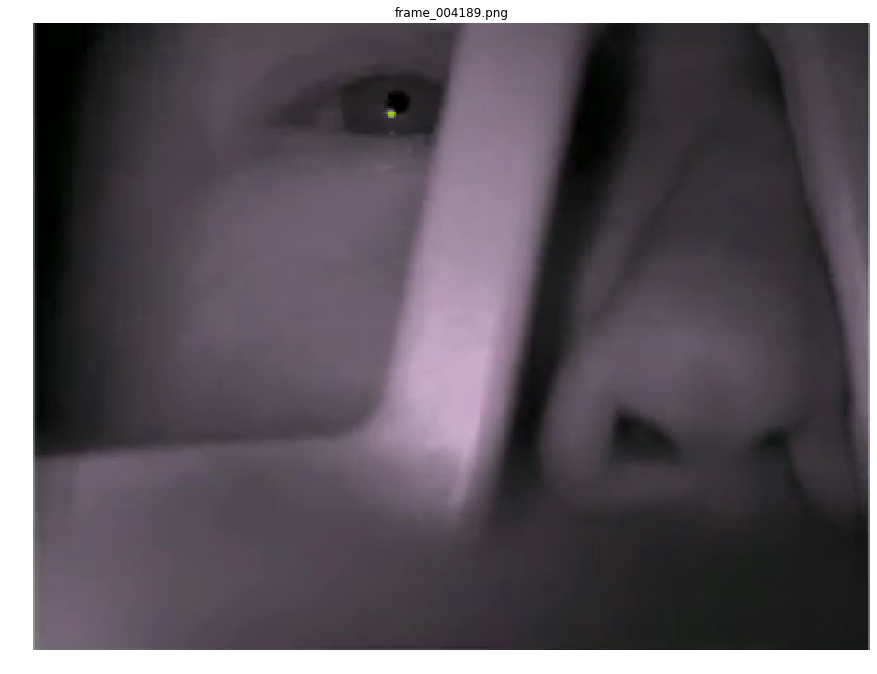

In [5]:
def show(df):
    img = df.values[np.random.randint(len(df))][-1]
    viz = os.path.join(FILEPATH+'{}'.format(img))
    image = cv2.imread(viz)
    plt.figure(figsize=(15, 15))
    plt.title(img)
    plt.axis("off")
    plt.imshow(image)
    plt.show()
    return image
test = show(timepose)

## Try evething you want

In [6]:
def showAvgchannel(img):
    average_color = np.average(img, axis=0)
    average_color_per_row = np.average(average_color, axis=0)
    return average_color_per_row
showAvgchannel(test)

array([74.64415456, 66.50463665, 75.22372208])

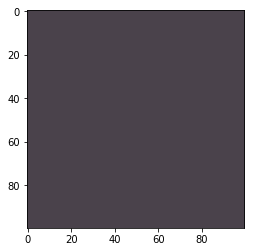

In [7]:
average_color_img = np.array([[showAvgchannel(test)]*100]*100, np.uint8)
plt.imshow(average_color_img) # So this is the average color of the image

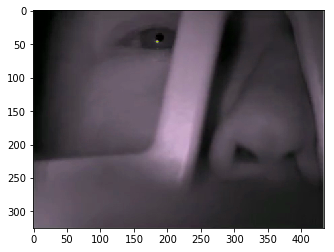

In [8]:
# HSV
test_hsv = cv2.cvtColor(test, cv2.COLOR_RGB2HSV)
test_gray = cv2.cvtColor(test, cv2.COLOR_RGB2GRAY)
plt.imshow(cv2.cvtColor(test_hsv, cv2.COLOR_HSV2RGB))


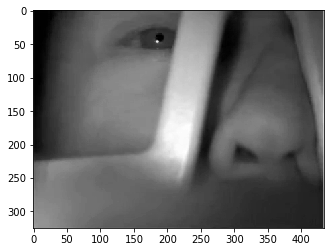

In [9]:
plt.imshow(test_gray,cmap = 'gray')

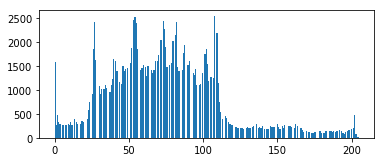

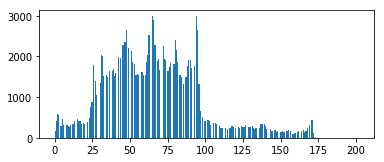

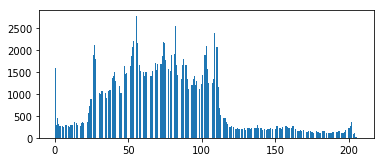

In [10]:
#ploting red hist
def plotHist(imgs):
    imgs = imgs.transpose(2,0,1)
    for ii, img in enumerate(imgs):
        fig = plt.figure(figsize=(6,8))
        ax = fig.add_subplot(3, 1, ii + 1)
        plt.hist(img.ravel(), bins=256)
        plt.show()
plotHist(test)

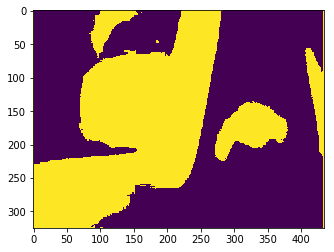

In [11]:
from skimage.filters import threshold_otsu,try_all_threshold
# Obtain the optimal otsu global thresh value by default setting
global_thresh = threshold_otsu(test_gray)
# Obtain the binary image by applying global thresholding
binary_global = test_gray > global_thresh
# Show the binary image obtained
plt.imshow(binary_global)

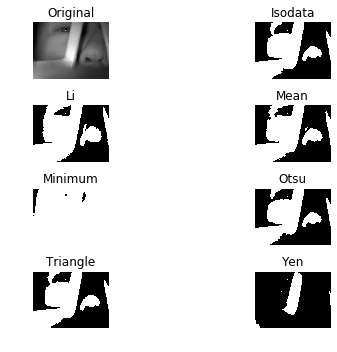

In [12]:
# Use the try all method on the grayscale image
fig, ax = try_all_threshold(test_gray, verbose=False)
# Show the resulting plots
plt.show()

## Edge Dection

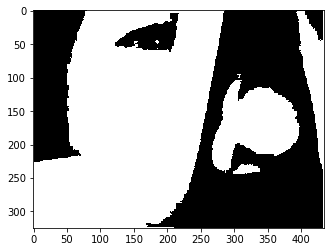

In [13]:
# threshold for grayscale image
_, threshold_img = cv2.threshold(test_gray, 60, 255, cv2.THRESH_BINARY)
threshold_img = cv2.cvtColor(threshold_img, cv2.COLOR_GRAY2RGB)
plt.imshow(threshold_img)

(325, 434)

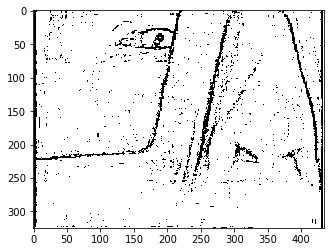

In [14]:
# By using the mean and gaussian to seperate the image
## 线性滤波：方框滤波、均值滤波、高斯滤波
th1 = cv2.adaptiveThreshold(test_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
th2 = cv2.adaptiveThreshold(test_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
plt.imshow(th2,cmap='gray')
th2.shape


## Filtering

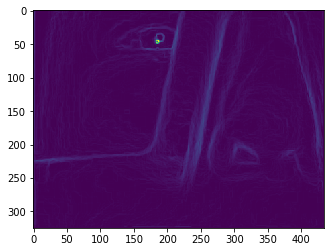

In [15]:
from skimage.filters import sobel
sobel_test = sobel(test_gray)
plt.imshow(sobel_test)


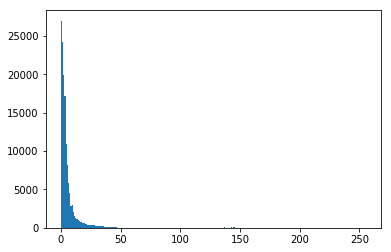

In [16]:
def histPlot(image):
    plt.hist(((image.ravel()- min(image.ravel()))/max(image.ravel())*255).astype('int'),bins=256)
    plt.show()

histPlot(sobel_test)

（canny、sobel、laplacian）

## Exposure

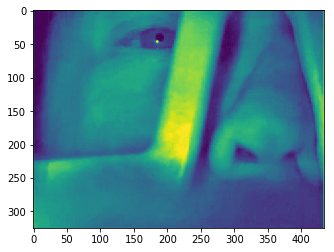

In [17]:
from skimage import exposure

# Use histogram equalization to improve the contrast
image_eq =  exposure.equalize_adapthist(test_gray)
plt.imshow(image_eq)

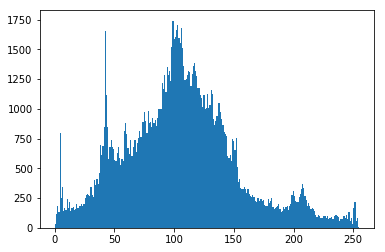

In [18]:
histPlot(image_eq)

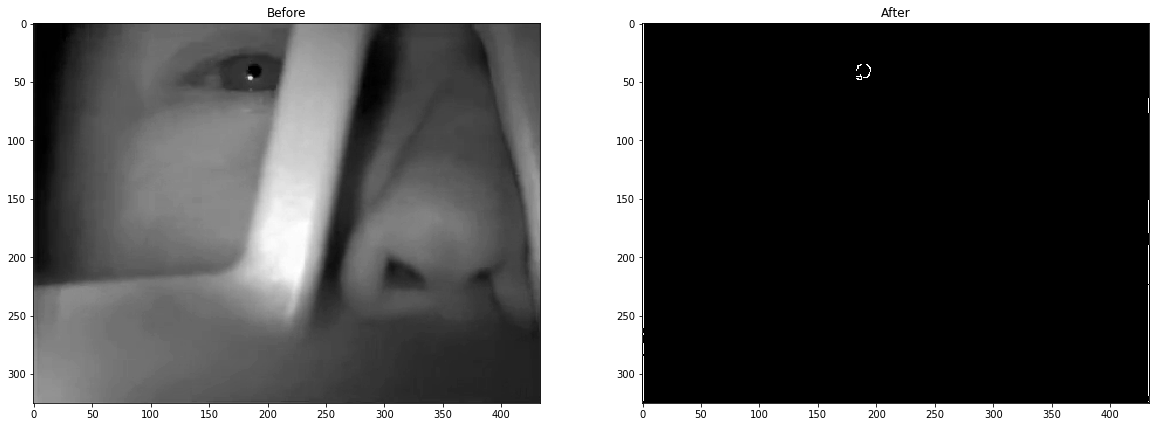

In [19]:
wide = cv2.Canny(test_gray, 100, 180) # 
tight = cv2.Canny(test_gray, 200, 240)

def showDiff(img,transform = cv2.Canny):
    transimg = transform(img, 100, 180)
    # Display the images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Before')
    ax1.imshow(img, cmap='gray')
    ax2.set_title('After')
    ax2.imshow(transimg, cmap='gray')

showDiff(test_gray)


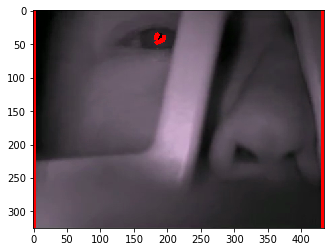

In [20]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on

low_threshold = 100
high_threshold = 180
edges = cv2.Canny(test, low_threshold, high_threshold)


rho = 1
theta = np.pi/180
threshold = 5
min_line_length = 5
max_line_gap = 5

line_image = np.copy(test) #creating an image copy to draw lines on

# Run Hough on the edge-detected image
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)


# Iterate over the output "lines" and draw lines on the image copy
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
        
plt.imshow(line_image)

Circles shape:  (1, 2, 3)


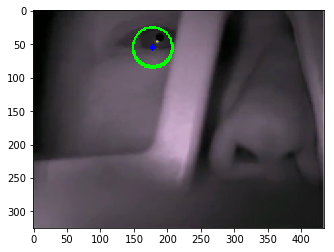

In [21]:
# for drawing circles on
circles_im = np.copy(test)

## TODO: use HoughCircles to detect circles
# right now there are too many, large circles being detected
# try changing the value of maxRadius, minRadius, and minDist
circles = cv2.HoughCircles(test_gray, cv2.HOUGH_GRADIENT, 1, 
                           minDist=1,
                           param1=70,
                           param2=11,
                           minRadius=21,
                           maxRadius=34)

# convert circles into expected type
circles = np.uint16(np.around(circles))
# draw each one
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(circles_im,(i[0],i[1]),i[2],(0,255,0),2) # 0,255,0 super green
    # draw the center of the circle
    cv2.circle(circles_im,(i[0],i[1]),2,(0,0,255),3)
    
plt.imshow(circles_im)

print('Circles shape: ', circles.shape)
    

Circles shape:  (1, 2, 3)


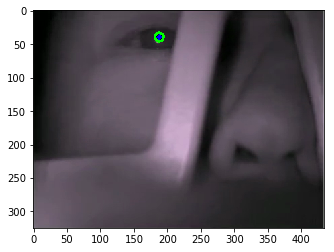

In [22]:
def findCircle(img):
    circles_im = np.copy(img)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 
                               minDist=1,
                               param1=75,
                               param2=11,
                               minRadius=2,
                               maxRadius=17)

    # convert circles into expected type
    circles = np.uint16(np.around(circles))
    # draw each one
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(circles_im,(i[0],i[1]),i[2],(0,255,0),2) # 0,255,0 super green
        # draw the center of the circle
        cv2.circle(circles_im,(i[0],i[1]),2,(0,0,255),3)

    plt.imshow(circles_im)

    print('Circles shape: ', circles.shape)

    
findCircle(test)

In [ ]:
# Define our color selection criteria in RGB values
lower_pink = np.array([30,0,0]) 
upper_pink = np.array([110,255,110])

# Define the masked area in RGB space
mask_rgb = cv2.inRange(test, lower_pink, upper_pink)

# mask the image
masked_image = np.copy(test)
masked_image[mask_rgb==0] = [0,0,0]

# Vizualize the mask
plt.imshow(masked_image)

In [ ]:
hsv = cv2.cvtColor(test, cv2.COLOR_RGB2HSV) # RGB 2 HSV

In [ ]:
# Define the masked area in HSV space
mask_hsv = cv2.inRange(hsv, lower_pink, upper_pink)

# mask the image
masked_image = np.copy(hsv)
masked_image[mask_hsv==0] = [0,0,0]

# Vizualize the mask
plt.imshow(masked_image)

### Try several ways to detect the eye in the image


In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
eye_cascade = cv2.CascadeClassifier ('haarcascades/haarcascade_eye.xml')


gray = cv2.cvtColor(test, cv2.COLOR_RGB2GRAY)

# find faces in image
faces = eye_cascade.detectMultiScale(gray)


# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [ ]:

plt.imshow(gray,cmap='gray')

In [ ]:
## try 
from collections import OrderedDict
FACIAL_LANDMARKS_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 35)),
	("jaw", (0, 17))
])


In [ ]:
!ls haarcascades/